# Tachiwin OCR
### For the Indigenous Languages of Mexico


This is a notebook for finetuning PaddleOCR-VL Finetuning to support the 68 indigenous languages of Mexico and their hundreths of variants which comprises a rich repertoire of non-standard latin glyphs which are not supported or barely supported on any OCR models.

This notebook is participating in the **ERNIE AI Developer Challenge** Hackathon of 2025

This notebooks provides an alternate method to finetune the model with unsloth.ai to compare performances between erniekit vs unsloth.


### Installation

In [1]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2
!pip intall wandb

### Unsloth

In [2]:
from unsloth import FastVisionModel
import torch
from transformers import AutoModelForCausalLM ,AutoProcessor

model_path = "unsloth/PaddleOCR-VL"
model, tokenizer = FastVisionModel.from_pretrained(
    model_path,
    max_seq_length = 2048, # Choose any for long context!
    load_in_4bit = False,     # 4bit uses much less memory
    load_in_8bit = False,    # A bit more accurate, uses 2x memory
    full_finetuning=True, # We support full finetuning now!
    auto_model=AutoModelForCausalLM,
    trust_remote_code = True,
    unsloth_force_compile = True,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


A new version of the following files was downloaded from https://huggingface.co/unsloth/PaddleOCR-VL:
- configuration_paddleocr_vl.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2025.12.8: Fast Paddleocr_Vl patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Float16 full finetuning uses more memory since we upcast weights to float32.


modeling_paddleocr_vl.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/unsloth/PaddleOCR-VL:
- modeling_paddleocr_vl.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.92G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/133 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.2M [00:00<?, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

We now load the processor

In [3]:
processor = AutoProcessor.from_pretrained(model_path, trust_remote_code=True)

processor_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

processing_paddleocr_vl.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/unsloth/PaddleOCR-VL:
- processing_paddleocr_vl.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


preprocessor_config.json:   0%|          | 0.00/641 [00:00<?, ?B/s]

image_processing_paddleocr_vl.py: 0.00B [00:00, ?B/s]

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

<a name="Data"></a>
### Data Prep
This in-house dataset was prepared _ex-profeso_ for this notebook which have been previously pre-processed and splitted to save GPU time with trivial task but you can check the full stack of datasets for different training premises

Dataset for pre-processed for current notebook  [here](https://huggingface.co/datasets/tachiwin/multilingual_ocr_llm_2). The original dataset is [here](https://huggingface.co/datasets/tachiwin/multilingual_ocr_llm).

In [5]:
from datasets import load_dataset
dataset = load_dataset("tachiwin/multilingual_ocr_llm_2", split = "train[:20000]")

README.md: 0.00B [00:00, ?B/s]

data/train-00000.parquet:   0%|          | 0.00/507M [00:00<?, ?B/s]

data/train-00001.parquet:   0%|          | 0.00/512M [00:00<?, ?B/s]

data/train-00002.parquet:   0%|          | 0.00/516M [00:00<?, ?B/s]

data/train-00003.parquet:   0%|          | 0.00/509M [00:00<?, ?B/s]

data/train-00004.parquet:   0%|          | 0.00/513M [00:00<?, ?B/s]

data/train-00005.parquet:   0%|          | 0.00/507M [00:00<?, ?B/s]

data/train-00006.parquet:   0%|          | 0.00/517M [00:00<?, ?B/s]

data/train-00007.parquet:   0%|          | 0.00/511M [00:00<?, ?B/s]

data/train-00008.parquet:   0%|          | 0.00/525M [00:00<?, ?B/s]

data/train-00009.parquet:   0%|          | 0.00/527M [00:00<?, ?B/s]

data/train-00010.parquet:   0%|          | 0.00/527M [00:00<?, ?B/s]

data/train-00011.parquet:   0%|          | 0.00/514M [00:00<?, ?B/s]

data/train-00012.parquet:   0%|          | 0.00/519M [00:00<?, ?B/s]

data/test-00000.parquet:   0%|          | 0.00/527M [00:00<?, ?B/s]

data/test-00001.parquet:   0%|          | 0.00/515M [00:00<?, ?B/s]

data/test-00002.parquet:   0%|          | 0.00/395M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Let's take an overview look at the dataset. We shall see what the 1st image is, and what caption it had.

In [6]:
dataset

Dataset({
    features: ['images', 'messages'],
    num_rows: 20000
})

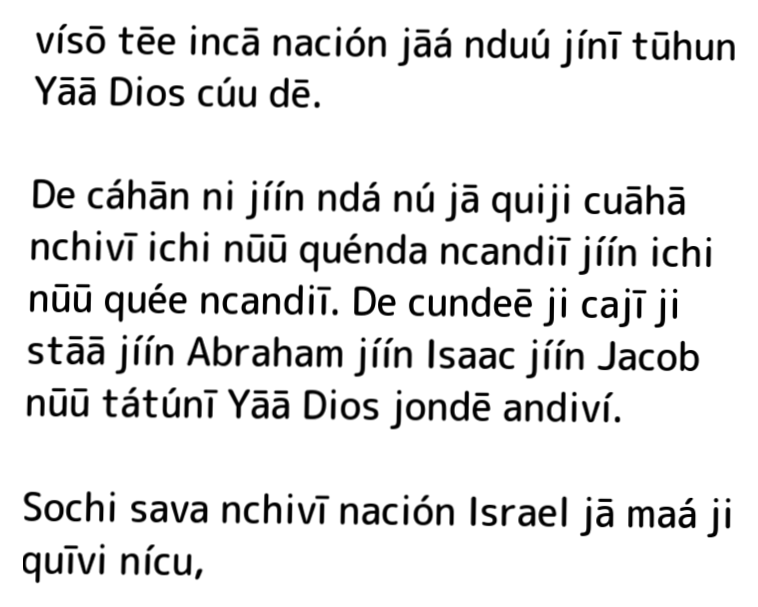

In [7]:
dataset[0]["images"][0]

<a name="Train"></a>
### Train the model
We use wandb for tracking progress and also its a good time to sign up to Huggingface. Please fill out with your own keys.

In [ ]:
import wandb
from huggingface_hub import login

wandb.login(key="")
login("", add_to_git_credential=True)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lsjcp (tachiwin) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [9]:
from trl import SFTTrainer, SFTConfig
from unsloth.trainer import UnslothVisionDataCollator

FastVisionModel.for_training(model) # Enable for training!

custom_collator = UnslothVisionDataCollator(
    model=model,
    processor=processor,
    ignore_index=-100,
    max_seq_length=2048,
    train_on_responses_only=True,
    instruction_part = "User: ",
    response_part = "\nAssistant:",
    pad_to_multiple_of = 8,
)

trainer = SFTTrainer(
    model = model,
    tokenizer = processor.tokenizer,
    data_collator = custom_collator,
    train_dataset = dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4, # Use GA to mimic batch size!
        warmup_steps = 12,
        # max_steps = 5000,
        num_train_epochs = 1,
        learning_rate = 5e-5,
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        logging_steps=10,
        report_to="wandb",
        save_strategy="steps",
        save_steps=200,
        save_total_limit=2,
        push_to_hub=True,
        hub_model_id="tachiwin/paddleocr_multilingual_checkpoints",
        hub_strategy="checkpoint",
        hub_private_repo=False,

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
    ),
)


In [10]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
3.867 GB of memory reserved.


if you are using a T4 free instance to train and get ran out time, you can resume the next day by setting RESUME to True, but mind you have to keep the setting to push the checkpoints to a different repo than the final repo for weights.


In [11]:
# @title Enable this is you want to resume from existing checkpoint

RESUME = False

if RESUME:
  from huggingface_hub import snapshot_download
  HF_CHECKPOINT_REPO = "tachiwin/paddleocr_multilingual_checkpoints"

  # Download only the last-checkpoint folder
  local_checkpoint_dir = snapshot_download(
      repo_id=HF_CHECKPOINT_REPO,
      repo_type="model",
      allow_patterns="last-checkpoint/*",  # Only download this folder
      local_dir="./checkpoints"
  )

added_tokens.json: 0.00B [00:00, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

configuration_paddleocr_vl.py: 0.00B [00:00, ?B/s]

generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

last-checkpoint/model.safetensors:   0%|          | 0.00/3.83G [00:00<?, ?B/s]

modeling_paddleocr_vl.py: 0.00B [00:00, ?B/s]

last-checkpoint/optimizer.pt:   0%|          | 0.00/2.48G [00:00<?, ?B/s]

last-checkpoint/rng_state.pth:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

last-checkpoint/scaler.pt:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

last-checkpoint/scheduler.pt:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

last-checkpoint/tokenizer.json:   0%|          | 0.00/11.2M [00:00<?, ?B/s]

last-checkpoint/tokenizer.model:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

trainer_state.json: 0.00B [00:00, ?B/s]

last-checkpoint/training_args.bin:   0%|          | 0.00/6.29k [00:00<?, ?B/s]

In [12]:
# @title Start training either resuming or not

if not RESUME:
  trainer_stats = trainer.train()
else:
  CHECKPOINT = f"{local_checkpoint_dir}/last-checkpoint"
  print(f"Resuming training from checkpoint: {CHECKPOINT}")
  trainer_stats = trainer.train(resume_from_checkpoint=CHECKPOINT)

Resuming training from checkpoint: /content/checkpoints/last-checkpoint


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 20,000 | Num Epochs = 1 | Total steps = 2,500
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 958,588,736 of 958,588,736 (100.00% trained)
	save_steps: 200 (from args) != 100 (from trainer_state.json)


wandb: Detected [huggingface_hub.inference, openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1010,0.703400
1020,0.692000
1030,0.604300
1040,0.779000
1050,0.605800
1060,0.647900
1070,0.535700
1080,0.700400
1090,0.574000
1100,0.575800


train/epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇█████
train/global_step,▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇████
train/grad_norm,▄▃▄▃▃▂▅▄▅▃▃▃▃▄▃▂▃▅▂▂▃▃▃▂▂▂▄█▂▂▃▁▃▁▃▄▂▂▁▃
train/learning_rate,████▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▁▁
train/loss,▇▇▆█▇█▅▆▅▇▆▅▄▅▄▄▄▄▃▆▄▂▄▃▃▂▂▂▂▂▂▃▁▃▄▂▂▇▁▂
total_flos,4.513321594098893e+16
train/epoch,1
train/global_step,2500
train/grad_norm,16.50799
train/learning_rate,0.0
train/loss,0.2836


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

771.2964 seconds used for training.
12.85 minutes used for training.
Peak reserved memory = 13.59 GB.
Peak reserved memory for training = 8.365 GB.
Peak reserved memory % of max memory = 92.192 %.
Peak reserved memory for training % of max memory = 56.746 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

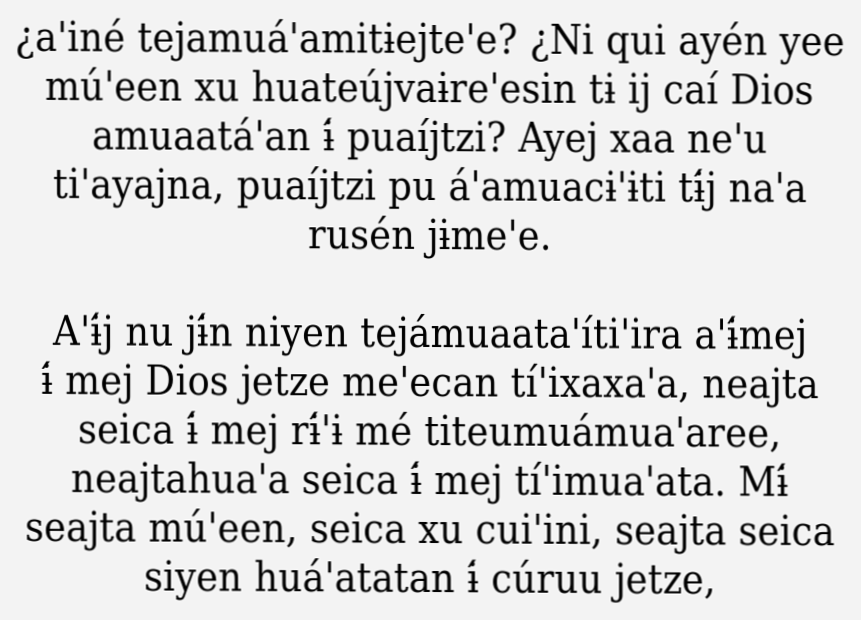

In [18]:
dataset[20]['images'][0]

In [19]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[20]['images'][0]

instruction = "OCR:"
messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]

text_prompt = processor.tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
    )

inputs = processor(
    image,
    text_prompt,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens=128,
                   use_cache=False, temperature=1.5, min_p=0.1)

―¿aꞌiné tejamuáꞌamitɨejteꞌe? ¿Ni qui ayén yee múꞌeen xu huateújvaɨreꞌesin tɨ ij caí Dios amuaatáꞌan ɨ́ puaíjtzi? Ayej xaa neꞌu tiꞌayajna, puaíjtzi pu áꞌamuacɨꞌɨti tɨ́j naꞌa rusén j


<a name="Save"></a>
### Saving, loading finetuned models
Now we save the final model and tokenizer to the HF, mind that as we are performing a full finetune and not LoRA, we do not need to merge.

In [13]:
model.push_to_hub("tachiwin/PaddleOCR-VL-Tachiwin") # Online saving
tokenizer.push_to_hub("tachiwin/PaddleOCR-VL-Tachiwin") # Online saving

README.md:   0%|          | 0.00/575 [00:00<?, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...1gora2n/model.safetensors:   0%|          | 16.7MB / 3.83GB            

Saved model to https://huggingface.co/tachiwin/PaddleOCR-VL-Tachiwin-LoRA


README.md:   0%|          | 0.00/581 [00:00<?, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...pu0uswht_/tokenizer.model: 100%|##########| 1.61MB / 1.61MB            

  ...mpu0uswht_/tokenizer.json: 100%|##########| 11.2MB / 11.2MB            

# Tachiwin
### May the indigenous languages never be lost.

In the loving memory of _Fidencio Hernández_

Know more about Tachiwin and the indigenous languages of México at https://tachiwin.org



```

     000000000
   000       000
  00 /\-----/\ 00
 00  \/     \/\ 00   ________
00  /  ^^   ^^ \ 00 !___  ___!
0   ! (0)  (0) !  0    | ||                  ()          ()
00  \/ /  / / /\ 00    | || ____  __  __  __ __ __ __ __ __ __ __
 00  \/  / / /  00     | ||  _|| // \ ||__|| || || || || || ||\||
  00 |\(())_/  00      | || / || ||   ||--|| || \\ || // || ||\||
   000|     \000       | || \_|| \\_/ ||  || ||  \//\\/  || || \|
     000000000        -------- ########################## -------

```

